# Scanning the R1 Peaks

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_loc = "D:/Beam Characterization/2019_3_22/"
fname = "2019_03_22.h5"

In [4]:
with h5py.File(data_loc+fname, 'r') as f:
    for name in f.keys():
        print(name)

1553279965 new spot
1553280729 R1 scan 1
1553281524 new spot 2
1553281729 R1 scan 2
1553284900 new spot 3
1553285317 new spot 3
1553285590 R1 scan 3
1553285939 new spot 4
1553286056 R1 scan 4
1553286113 R1 scan 4
1553286438 new spot 5


In [5]:
run_name = "1553281729 R1 scan 2"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

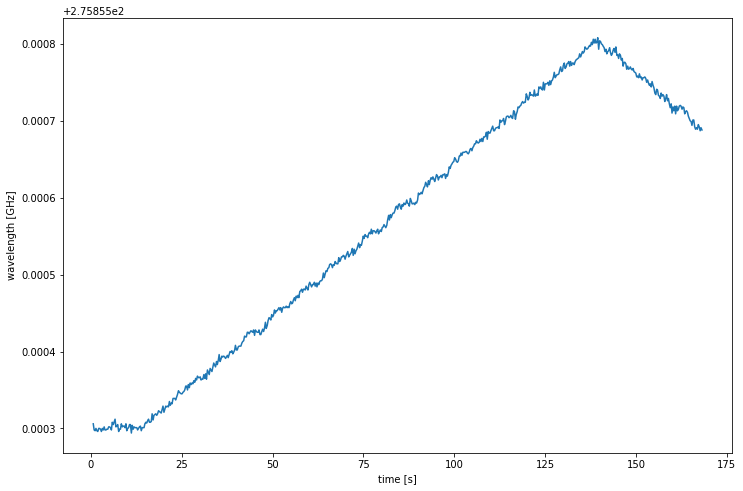

In [6]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [7]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

328


Text(0.5, 0, 'time [ms]')

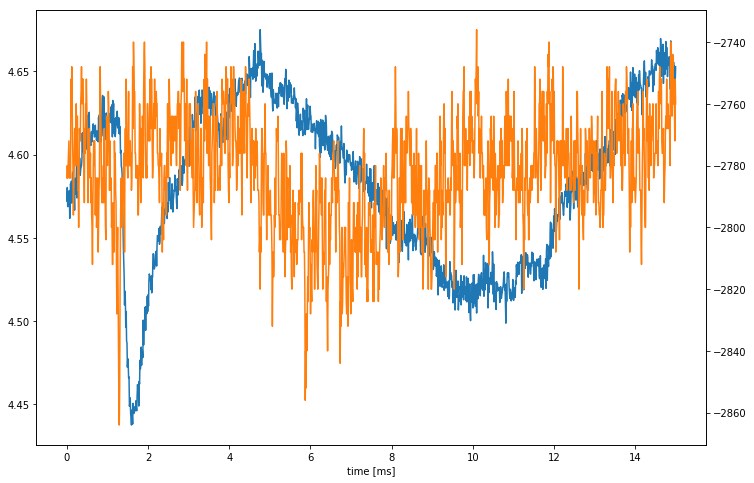

In [8]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

In [9]:
import datetime as dt

scan_name = '2019-3-22 R1 scan 1.lvm'

def find_nearest_value(set_val, val1, val2):
    if (np.abs(set_val - val1) > 70) & (np.abs(set_val - val2) > 70):
        return np.nan
    elif np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    nan_counter = 0
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        nearest = find_nearest_value(b,c,d)
        
        if np.isnan(nearest):
            nan_counter += 1
            continue
        frequencies.append((t,b,nearest))
    frequencies = np.array(frequencies)
print(nan_counter)

4376


Text(0, 0.5, 'frequency relative to Cs [MHz]')

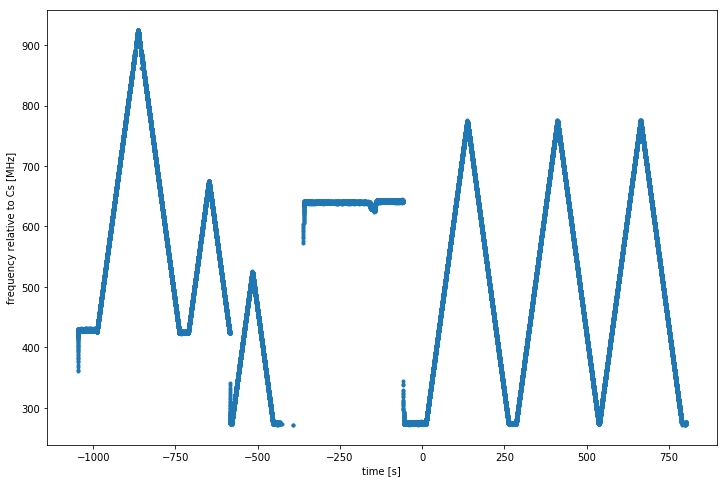

In [10]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0],frequencies[:,2],'.')
ax.set_xlabel('time [s]')
ax.set_ylabel('frequency relative to Cs [MHz]')

In [11]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1100], dx=dx)-9*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

100%|█████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 20602.80it/s]


In [12]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.85)]))
frequency_values = np.array(frequency_values)

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)  

In [13]:
start, stop = 0, -1

frequency_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


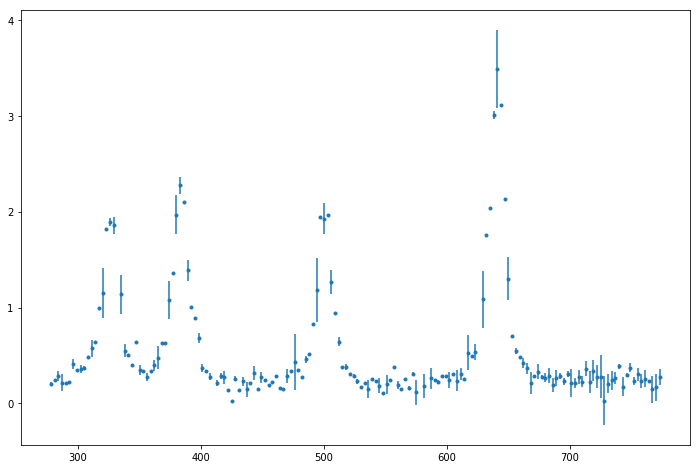

In [14]:
fit_array = frequency_amp[frequency_amp[:,0].argsort()]

df = 3
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');

In [16]:
f_bins

array([276.613617, 279.613617, 282.613617, 285.613617, 288.613617,
       291.613617, 294.613617, 297.613617, 300.613617, 303.613617,
       306.613617, 309.613617, 312.613617, 315.613617, 318.613617,
       321.613617, 324.613617, 327.613617, 330.613617, 333.613617,
       336.613617, 339.613617, 342.613617, 345.613617, 348.613617,
       351.613617, 354.613617, 357.613617, 360.613617, 363.613617,
       366.613617, 369.613617, 372.613617, 375.613617, 378.613617,
       381.613617, 384.613617, 387.613617, 390.613617, 393.613617,
       396.613617, 399.613617, 402.613617, 405.613617, 408.613617,
       411.613617, 414.613617, 417.613617, 420.613617, 423.613617,
       426.613617, 429.613617, 432.613617, 435.613617, 438.613617,
       441.613617, 444.613617, 447.613617, 450.613617, 453.613617,
       456.613617, 459.613617, 462.613617, 465.613617, 468.613617,
       471.613617, 474.613617, 477.613617, 480.613617, 483.613617,
       486.613617, 489.613617, 492.613617, 495.613617, 498.613

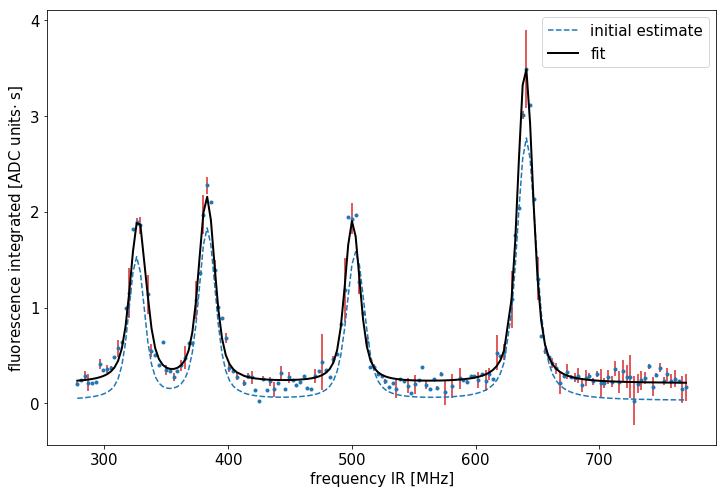

In [15]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

names = ['P_0', 'P_1', 'P_2', 'P_3']

idx_offset = 1

minimum_peak_height = 0.45
distance = 40/np.diff(midpoint)[0]/4
width = 30/np.diff(midpoint)[0]/4
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if bin_means[len(bin_means)-int(1.5*distance):].max() >= minimum_peak_height:
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if bin_means[:int(1.5*distance)].max() >= minimum_peak_height:
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P_'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

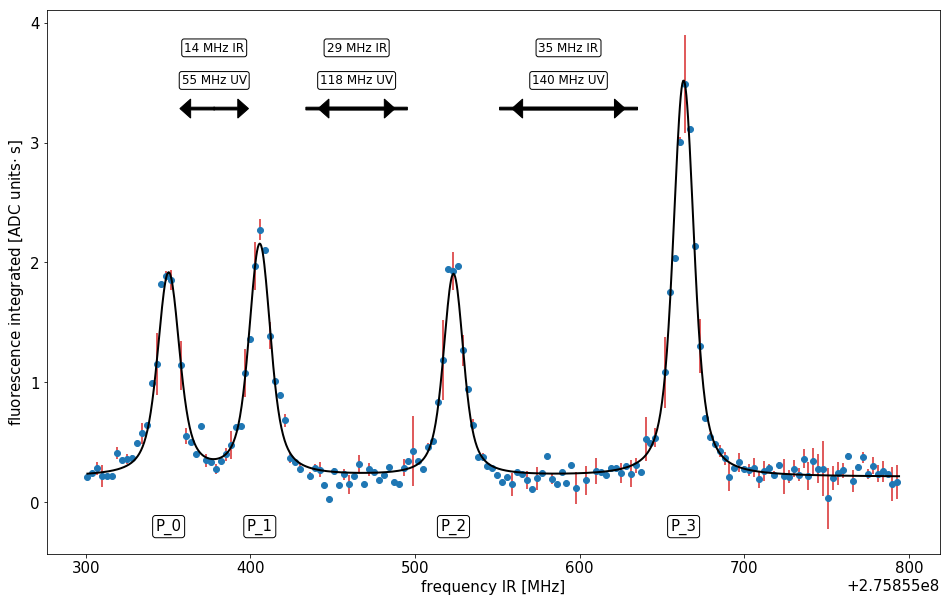

In [81]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = frequency_amp_wavemeter_cal[0,0]*1e3-x[0]
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar(x+x_offset,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot(fit_x+x_offset, model.eval(result.params, x=fit_x), 'k-', lw = 2)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
height_arrow = 0.8*ylim[1]
height_dist = 0.85*ylim[1]
height_peakl = 0.05*np.diff(ylim)+ylim[0]
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = [f.prefix.strip('_') for f in fit_models]
for ploc, dist, lab in zip(plocs, np.diff(plocs), labels):
    ploc += x_offset
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+0.06*np.diff(ylim),'{0:.0f} MHz IR'.format(dist/4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28),height_arrow,(dist-28*2.5),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)
    ax.arrow((ploc+(dist-28)),height_arrow,(-(dist-28*2.5)),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)

ax.text((plocs[-1]+x_offset),height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


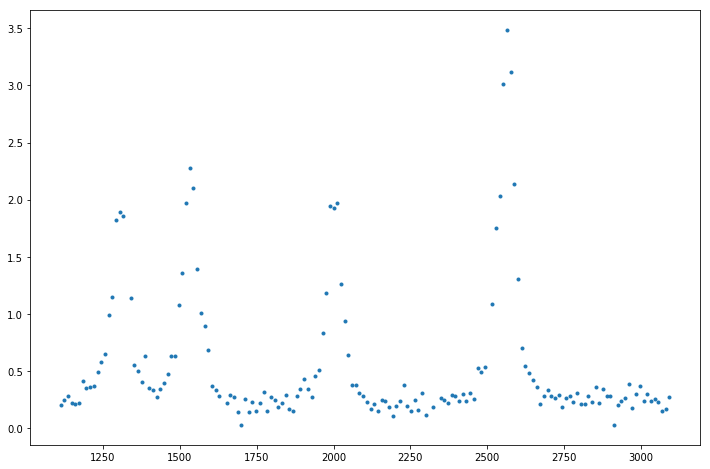

In [82]:
fit_array = frequency_amp[frequency_amp[:,0].argsort()]
fit_array[:,0] *= 4

df = 12
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

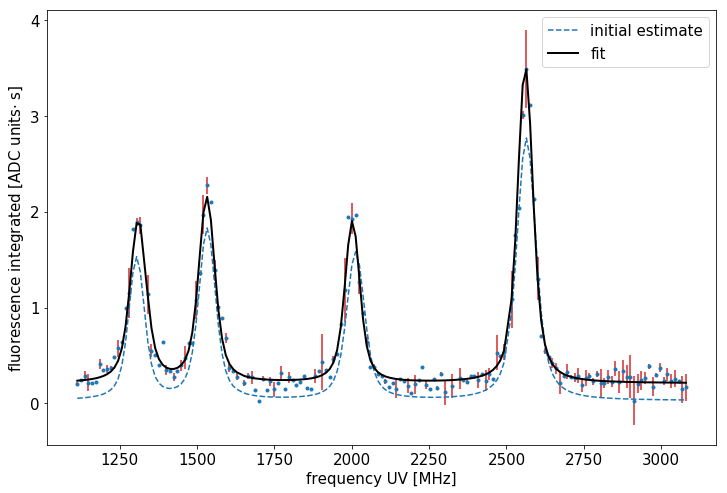

In [83]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

idx_offset = 1

minimum_peak_height = 0.45
distance = 40/np.diff(midpoint)[0]
width = 30/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if bin_means[len(bin_means)-int(1.5*distance):].max() >= minimum_peak_height:
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if bin_means[:int(1.5*distance)].max() >= minimum_peak_height:
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P_'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

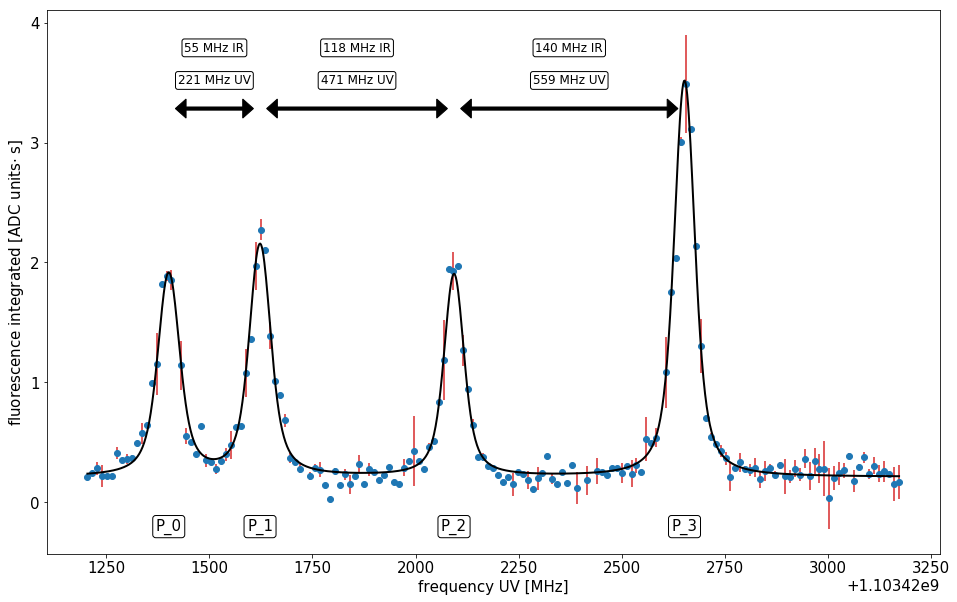

In [84]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = frequency_amp_wavemeter_cal[0,0]*1e3*4-x[0]
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar(x+x_offset,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot(fit_x+x_offset, model.eval(result.params, x=fit_x), 'k-', lw = 2)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
height_arrow = 0.8*ylim[1]
height_dist = 0.85*ylim[1]
height_peakl = 0.05*np.diff(ylim)+ylim[0]
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = [f.prefix.strip('_') for f in fit_models]
for ploc, dist, lab in zip(plocs, np.diff(plocs), labels):
    ploc += x_offset
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+0.06*np.diff(ylim),'{0:.0f} MHz IR'.format(dist/4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28),height_arrow,(dist-28*2.5),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)
    ax.arrow((ploc+(dist-28)),height_arrow,(-(dist-28*2.5)),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)

ax.text((plocs[-1]+x_offset),height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

In [85]:
for key in result.best_values:
    if 'center' in key:
        print("{0:15} : {1:.0f} MHz".format(key, result.best_values[key]/4))

P_3_center      : 640 MHz
P_2_center      : 500 MHz
P_1_center      : 383 MHz
P_0_center      : 327 MHz


In [86]:
for key in result.best_values:
    if 'center' in key:
        print("{0:15} : {1:.3f} GHz".format(key, result.best_values[key]/4/1e3+(frequency_amp_wavemeter_cal[0,0]-x[0]/4/1e3)))
        

P_3_center      : 275855.663 GHz
P_2_center      : 275855.523 GHz
P_1_center      : 275855.406 GHz
P_0_center      : 275855.350 GHz


## Scan 3 Scanning around a single R1 peak; the second one

In [19]:
run_name = "1553285590 R1 scan 3"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

In [20]:
import datetime as dt

scan_name = '2019-3-22 R1 scan 3.lvm'

def find_nearest_value(set_val, val1, val2):
    if (np.abs(set_val - val1) > 70) & (np.abs(set_val - val2) > 70):
        return np.nan
    elif np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    nan_counter = 0
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        nearest = find_nearest_value(b,c,d)
        
        if np.isnan(nearest):
            nan_counter += 1
            continue
        frequencies.append((t,b,nearest))
    frequencies = np.array(frequencies)
print(nan_counter)

76


100%|█████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 17135.68it/s]


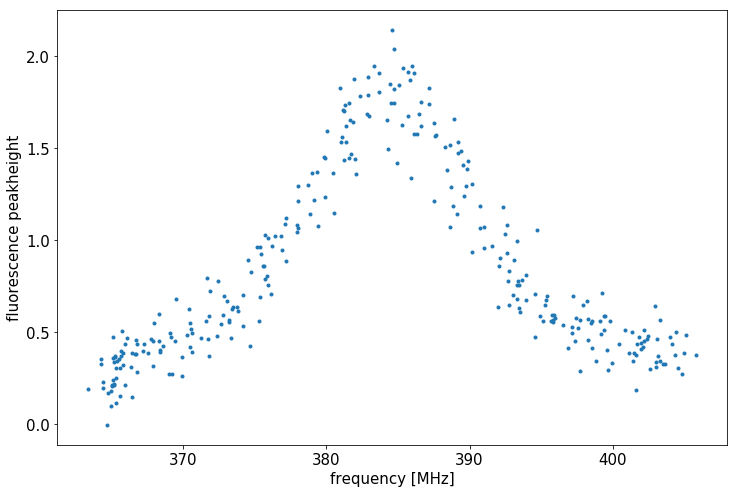

In [21]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1100], dx=dx)-9*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.85)]))
frequency_values = np.array(frequency_values)

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)  

start, stop = 0, -1

frequency_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

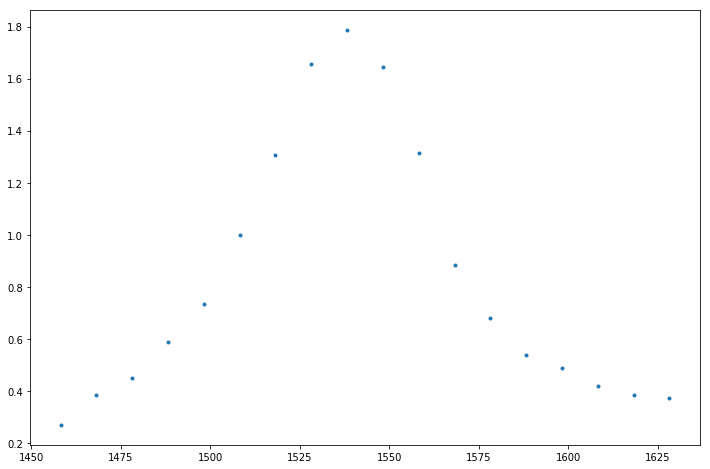

In [22]:
fit_array = frequency_amp[frequency_amp[:,0].argsort()]
fit_array[:,0] *= 4

df = 10
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

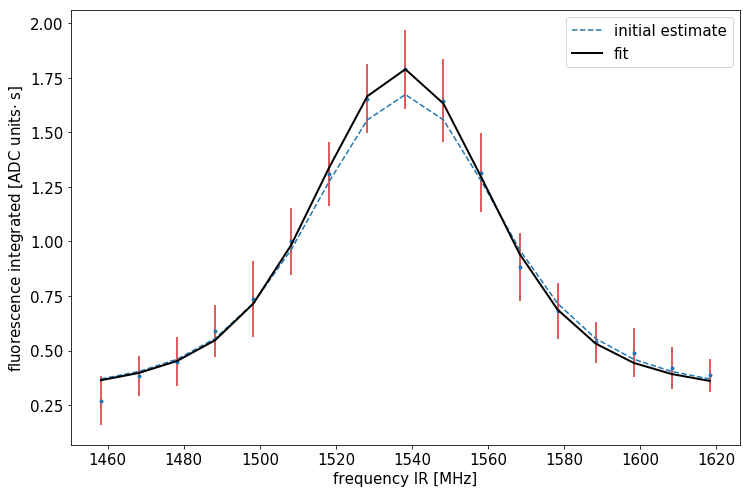

In [23]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

names = []

idx_offset = 1

minimum_peak_height = 1
distance = 40/np.diff(midpoint)[0]
width = 30/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if (peaks[0][-1] <= len(bin_means)-1-distance) and (bin_means[len(bin_means)-int(1*distance):].max() >= minimum_peak_height):
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if (peaks[0][0] <= 1*distance) and (bin_means[:int(1*distance)].max() >= minimum_peak_height):
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

## Scan 4 Scanning around a single R1 peak; the fourth one

In [24]:
run_name = "1553286113 R1 scan 4"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

In [25]:
import datetime as dt

scan_name = '2019-3-22 R1 scan 4.lvm'

def find_nearest_value(set_val, val1, val2):
    if (np.abs(set_val - val1) > 70) & (np.abs(set_val - val2) > 70):
        return np.nan
    elif np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    nan_counter = 0
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        nearest = find_nearest_value(b,c,d)
        
        if np.isnan(nearest):
            nan_counter += 1
            continue
        frequencies.append((t,b,nearest))
    frequencies = np.array(frequencies)
print(nan_counter)

100


100%|█████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 19315.63it/s]


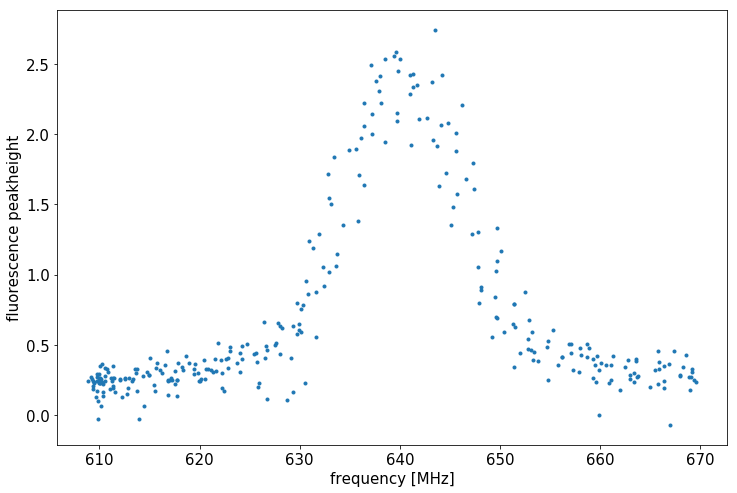

In [26]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1100], dx=dx)-9*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.85)]))
frequency_values = np.array(frequency_values)

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)  

start, stop = 0, -1

frequency_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

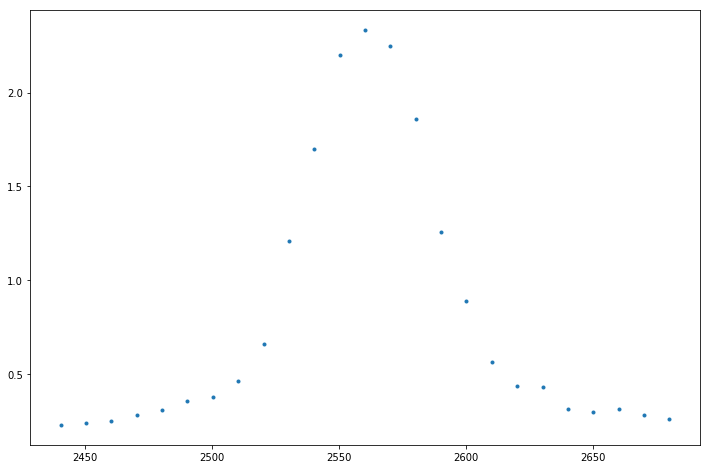

In [27]:
fit_array = frequency_amp[frequency_amp[:,0].argsort()]
fit_array[:,0] *= 4

df = 10
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

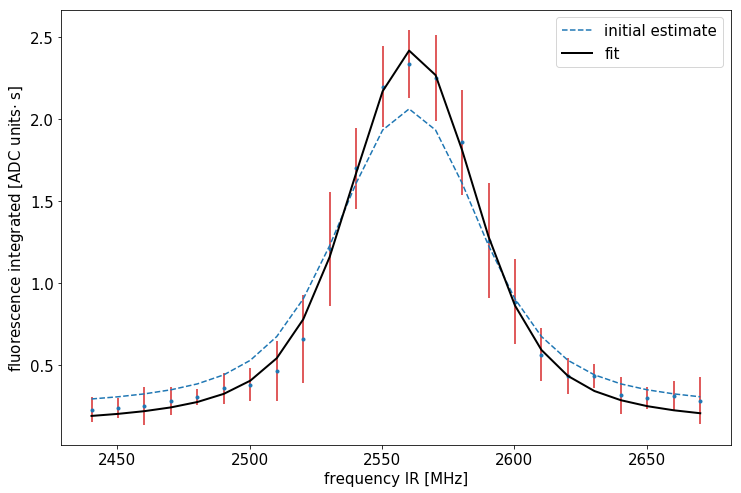

In [28]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

names = []

idx_offset = 1

minimum_peak_height = 1
distance = 40/np.diff(midpoint)[0]
width = 30/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if bin_means[len(bin_means)-int(distance):].max() >= minimum_peak_height:
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if bin_means[:int(distance)].max() >= minimum_peak_height:
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

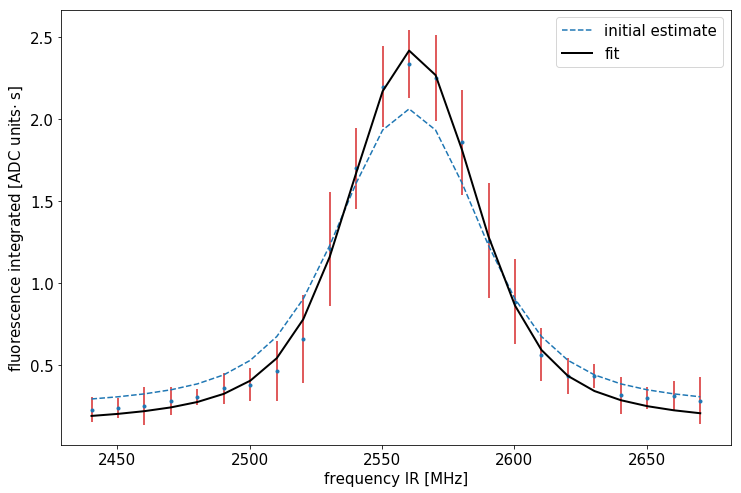

In [29]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

names = []

idx_offset = 1

minimum_peak_height = 0.45
distance = 40/np.diff(midpoint)[0]
width = 30/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if (peaks[0][-1] <= len(bin_means)-1-distance) and (bin_means[len(bin_means)-int(1*distance):].max() >= minimum_peak_height):
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if (peaks[0][0] <= 1*distance) and (bin_means[:int(1*distance)].max() >= minimum_peak_height):
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

In [30]:
print(result.fit_report())

[[Model]]
    (Model(offset) + Model(voigt, prefix='P_1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 24
    # variables        = 4
    chi-square         = 0.00259231
    reduced chi-square = 1.2962e-04
    Akaike info crit   = -211.198225
    Bayesian info crit = -206.486009
[[Variables]]
    offset:         0.12841446 +/- 0.03870629 (30.14%) (init = 0.2295168)
    P_1_sigma:      16.0515984 +/- 0.41810402 (2.60%) (init = 17.96751)
    P_1_center:     2561.56384 +/- 0.30942457 (0.01%) (init = 2560.259)
    P_1_amplitude:  176.292353 +/- 6.29402501 (3.57%) (init = 157.7376)
    P_1_gamma:      16.0515984 +/- 0.41810401 (2.60%) == 'P_1_sigma'
    P_1_fwhm:       57.8064709 +/- 0.91561551 (1.58%) == '1.0692*P_1_gamma+sqrt(0.8664*P_1_gamma**2+5.545083*P_1_sigma**2)'
    P_1_height:     2.29222345 +/- 0.05938890 (2.59%) == '(P_1_amplitude/(P_1_sigma*sqrt(2*pi)))*wofz((1j*P_1_gamma)/(P_1_sigma*sqrt(2))).real'
[[Correlations]] (